In [2]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

'%.4f'

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

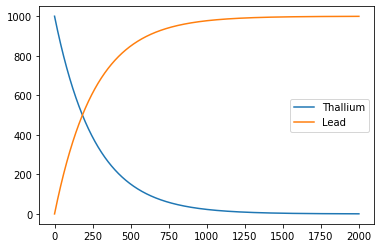

In [3]:
np.random.seed = 123

it = 2000

NT = np.zeros(it)
NL = np.zeros(it)

NT[0]=1000
NL[0]=0

T = 3.052*60
def p(t):
    return 1-2**(-t/T)

for t in range(it):
    if t>0:
        NT[t] = NT[0]*(1-p(t))
        NL[t] = NT[0]-NT[t]
    
x = np.arange(it)
plt.plot(x, NT, label='Thallium')
plt.plot(x, NL, label='Lead')
plt.legend()

Text(0, 0.5, '# atoms')

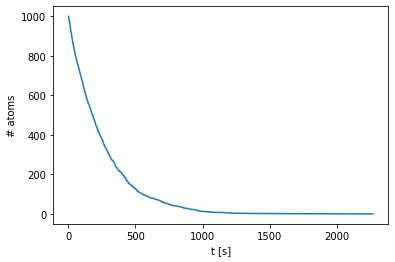

In [4]:
def dec_pdf(x):
    return 2**-(t/T)*np.log(2)/T

def dec_icdf(p):
    return - np.log(1-p) * T / np.log(2.0)

it1=1000

NT1 = np.zeros(it1)
NT1[0] = 1000

for t in range(it1):
    if t>0:
        p = np.random.uniform(0, 1)
        NT1[t] = dec_icdf(p)
        
NT1 = np.sort(NT1)        
 
y = np.linspace(it1, 0, it1)
plt.plot(NT1, y)
plt.xlabel('t [s]')
plt.ylabel('# atoms')

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [34]:
N = 1000000
a_0 = 52.9e3  # fm

x = np.random.normal(0, a_0/100.0, size=N)
y = np.random.normal(0, a_0/100.0, size=N)

e2 = 1.44 * 2.0 # MeV*fm
def theta(x,y, Z=79, E=7.7):
    b = np.sqrt(x*x + y*y)
    f = (Z*e2) / (E*b)      #2 pi e_0 = 1
    return 2 * np.arctan(f)

thetas = theta(x, y)

thetas_bounced = thetas[thetas >= np.pi/2.0]
len(thetas_bounced)

1617

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

1.45099
0.002222075606274434


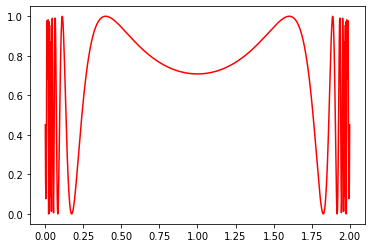

In [16]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.001,1.999,1000)
plt.plot(x,f(x),'r-')

# Monte Carlo integration, hit or miss
def hom(f):
    N=100000
    count=0
    for i in range(N):
        x=2*np.random.random()
        y=np.random.random()
        if y<f(x): count+=1
    I=2*count/N
    return I

I_list = []
for i in range(10):
    I_list.append(hom(f))
    
I_vec = np.array(I_list)
I = np.mean(I_vec)
err = np.std(I_vec)

print(I)
print(err)

In [11]:
#mean value method
count=0
value = []
for i in range(N):
    x=np.random.uniform(0,2, 1)
    count +=f(x)
    value.append(f(x))
I=2*count/N
print(I)

np_val = np.array(value)
err = 2 * np.std(np_val) / np.sqrt(N)
print(err)

[1.4511]
0.0016660626542017638


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [17]:
def f(x):
    x2 = np.sum(x**2)
    if x2 <= 1:
        return 1
    else:
        return 0
        

def I_sphere(dim):
    N=100000
    x = np.random.uniform(-1.0, 1.0, size=(N,dim))
    val = np.zeros(N)
    for i in range(N):
        val[i] = f(x[i])
    V = (2.0**dim)*np.mean(fs)
    return V

V_2  = I_sphere(2 )
V_10 = I_sphere(10)

print(" 2-D: V=", V_2 )
print("10-D: V=", V_10)

 2-D: V= 3.1436
10-D: V= 2.47808


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [3]:
def w(x):
    return 1.0 / np.sqrt(x)

def inv_tr_w(x):
    return x*x #/ 4.0

def Iw(a, b):
    return 2.0 * (np.sqrt(b) - np.sqrt(a))

def f(x):
    return x**(-0.5) / (np.exp(x) + 1)

def I_imp_samp(N, a, b):
    x = np.random.uniform(a, b, size=N)
    ws = inv_tr_w(x)
    fraq = f(ws) / w(ws)
    #fraq = f(x)/w(x)
    return np.mean(fraq) * Iw(a,b)

N = 1000000
I = I_imp_samp(N,0,1.0)
print(I)

0.8388063798136491
